#### Data:
The network will be trained on 1000 words and tested on 548.  All data will be transformed into semantic and phonological representations. The phonoligcal transformation processes followed two distinct steps. First, Arpabet [8] was utilized create phonological representations of the sound sequences in each word.  The coding scheme with examples is provide in Table 1. This function was completed automatically through an online transcription tool at http://www.speech.cs.cmu.edu/cgi-bin/cmudict. Then binary (0,1) vectors for the representations of each phoneme needed to create each word were created. There was also a stop element in the phoneme input/output data with the intended purpose of informing the network when the ending of each phoneme sequence. 
	The semantic input consisted of a similarity matrix constructed from word embeddings from each word. Each word’s embedding is a vector with a length of 100. The vector for a single word is its distributed representation based on the use of each word in a twenty-six gigabyte corpus of linguistic data from Googles Newswire [9]. The similarity matrix is conducted of the cosine distance between each 100 element vector.  Each words input data in the semantic layer is their 1000 element word similarity vector. 

Data visualization:
I am still working on a good way to visually present the data.  I followed the xamples from the network visualization lecture; however, I think the data has too many dimensions to be effectively plotted this way.  Figure 2 presents the entire lexicons network and Figure 3 presents the network for 628 words similarities with the word ostrich.  I find Figure 3 concerning because the results are not easily interpreted. For example, I would have expected to have more animals clustered to ostrich. As can be seen this is not the case in Figure 3 and not recognizable in Figure 2.  More work is to come on this.  To be continued…

# insert table 1 here

#### Model configuration:
The network was constructed based off the Lichteim 2 model from Ueno and colleagues [3] and is displayed in Figure 1. The network architecture is informed by the assumptions of dual stream models of language [1], [2] with blue and red arrows representing the phonological (dorsal) and semantic (ventral) processing streams.  Each layer is also labeled as to its presumed cortical representation.  Pytorch [6] was utilized to construct the network, which contains bidirectional activation between three input/output layers, which contain a minimum of one hidden layer between each. The two input layers include semantics and phonology, which are both connected to output phonology. The input phonology and output phonology are connected by a single hidden layer with the aim of modeling a word repetition task.  Given the sequential processing of speech sounds that is necessary to complete such a task two processes were constructed in the model.  First, model recieves each phoneme of each word in sequential steps. For example the d, o, and g are delivered in three unique time steps.  To account for sequential processing of speech sounds, the hidden layer between input and output phonology includes a recurrent loop [7].  The semantic and output phonology path was designed to imitate a picture naming task and includes two hidden layers. Finally, auditory comprehension is modeled through the following connection: input phonology, semantics, to output phonology. 

#### Figure 1: Visual schematic of the Comprehension, Production, and Repetition neural network (Modified from Ueno and colleagues [3])
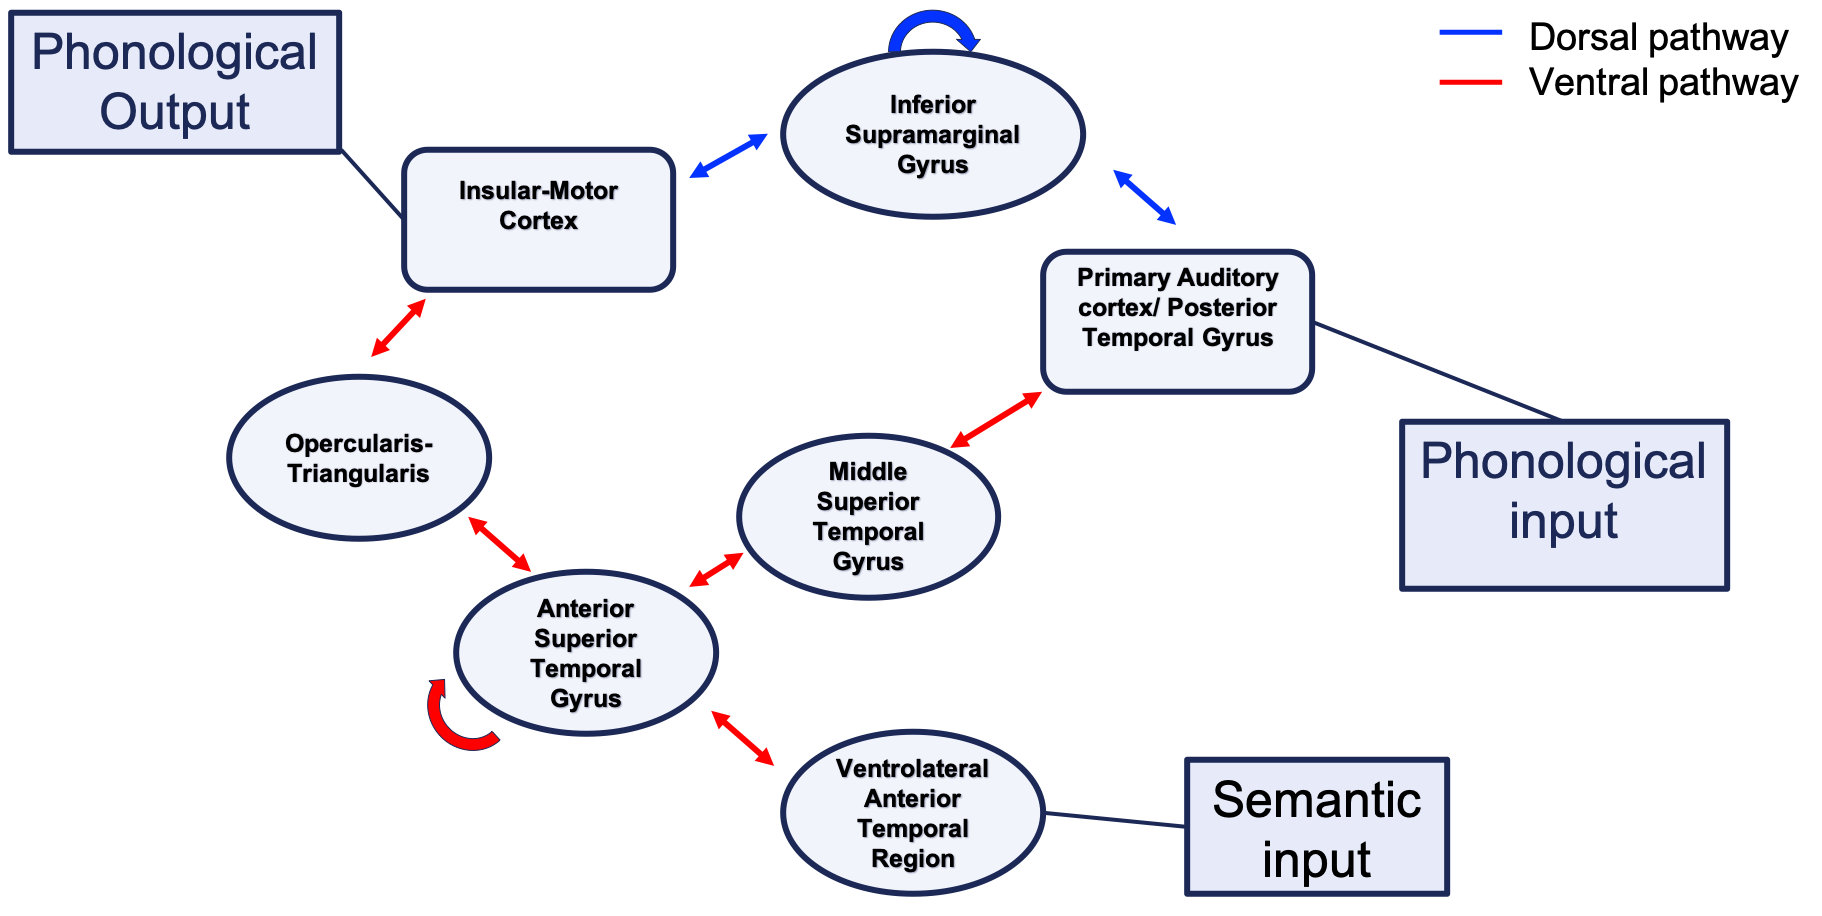
* Note: 
 1) Square boxes denote where the input layer is, and are NOT the input layer itself 
 2) Curved arrows represent a recurrent loop 

In [2]:
import gensim
from gensim.matutils import corpus2csc
from gensim.corpora import Dictionary
import pandas as pd
import numpy as np

#### Loading data and converting each to utilize in the semantic input layer. I do not know what is the better way to do this, so I my goal is to understand how to set up this input layer for both methods.
 1. Method one is an array of word embeddings of all the words that can be found in the wiki gigaword database
 2. Method two is a similarity matrix based on the word embeddings for all the words within the wikigigaworld database

In [3]:
#Load data
import pandas as pd
from pandas import DataFrame
words = pd.read_csv('DRitems.csv')
#words.columns = ['Number', 'Word']

df = DataFrame(words, columns= ['Word'])
df_list = df.values.tolist()

In [4]:
#Method 1: Get word embeddings for all available words from Wikigigaworld.
import gensim.downloader as api
# Download dataset
glove_model300 = api.load('glove-wiki-gigaword-300')
#create np array called word_array
word_array = np.empty((0, 300))
not_found = []
for idx, row in words.iterrows():
    try:
        result = glove_model300.word_vec(row[0])
        word_array = np.append(word_array, [result], axis = 0)
    except KeyError:
        not_found.append(row[0]) 

In [5]:
#Method 2: Create similarity matrix
from pandas import DataFrame
words = pd.read_csv('wordlist.csv')
#words.columns = ['Number', 'Word']
words

df = DataFrame(words, columns= ['Word'])
df_list = df.values.tolist()
#print(df_list)
#print(df)

from itertools import combinations
#convert pandas df to list
word_list = words['Word'].tolist()
#create every combination of items in the word list, the two is the number of comparisons
comb = list(combinations(word_list, 2))
network = []
for pair in comb: 
    temp = []
    temp.append(pair[0])
    temp.append(pair[1])
    try:
        temp.append(glove_model300.similarity(pair[0], pair[1]))
    except:
        temp.append(-999) # Term not found

    network.append(temp)
#create similarity matrix    
df_similarity = pd.DataFrame(network, columns=['origin','target','similarity'])
df_similarity.head()

,origin,target,similarity
0,ant,bear,0.110003
1,ant,beaver,0.216053
2,ant,bee,0.359626
3,ant,bird,0.239848
4,ant,bug,0.335570


In [6]:
phon = pd.read_csv('Words w transcription.csv')

In [7]:
df_similarity

,origin,target,similarity
0,ant,bear,0.110003
1,ant,beaver,0.216053
2,ant,bee,0.359626
3,ant,bird,0.239848
4,ant,bug,0.335570
...,...,...,...
1197373,flower,tree,0.460653
1197374,flower,volcano,-0.007444
1197375,mountain,tree,0.299330
1197376,mountain,volcano,0.381293


In [8]:
phon

,ant,AE,N,T,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12,Unnamed: 13,Unnamed: 14
0,bear,B,AE,ER,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,beaver,B,IY,V,ER,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,bee,B,IY,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,bird,B,ER,D,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,bug,B,AH,G,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1542,map,M,AE,P,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1543,flower,F,L,AW,ER,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1544,mountain,M,AW,N,T,AH,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1545,tree,T,R,IY,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
# phon = phon[['ant','AE', 'N' ,'T']]

In [10]:
phon

,ant,AE,N,T,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12,Unnamed: 13,Unnamed: 14
0,bear,B,AE,ER,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,beaver,B,IY,V,ER,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,bee,B,IY,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,bird,B,ER,D,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,bug,B,AH,G,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1542,map,M,AE,P,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1543,flower,F,L,AW,ER,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1544,mountain,M,AW,N,T,AH,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1545,tree,T,R,IY,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
phon.fillna('', inplace = True)

In [12]:
phon.head()

,ant,AE,N,T,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12,Unnamed: 13,Unnamed: 14
0,bear,B,AE,ER,,,,,,,,,,,
1,beaver,B,IY,V,ER,,,,,,,,,,
2,bee,B,IY,,,,,,,,,,,,
3,bird,B,ER,D,,,,,,,,,,,
4,bug,B,AH,G,,,,,,,,,,,


In [13]:
phon.columns = ['Word', '1', '2', '3', '4', '5', '6','7', '8', '9', '10', '11','12', '13', '14']

In [14]:
phon.columns

Index(['Word', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12',
       '13', '14'],
      dtype='object')

# Label Encoding

In [15]:
from sklearn import preprocessing 

In [16]:
import torch
import torch.nn as nn

In [17]:
label_encoder = preprocessing.LabelEncoder() 

In [18]:
X = phon['Word']

In [19]:
y = phon.drop(['Word'], axis = 1)

In [20]:
X.shape

(1547,)

In [21]:
y.shape

(1547, 14)

In [22]:
y.head()

,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,B,AE,ER,,,,,,,,,,,
1,B,IY,V,ER,,,,,,,,,,
2,B,IY,,,,,,,,,,,,
3,B,ER,D,,,,,,,,,,,
4,B,AH,G,,,,,,,,,,,


In [23]:
# for col in y:
#     y[col] = label_encoder.fit_transform(y[col]) 

In [24]:
X.values

array(['bear', 'beaver', 'bee', ..., 'mountain', 'tree', 'volcano'],
      dtype=object)

In [25]:
df_phon = phon.copy()

In [26]:
df_phon

,Word,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,bear,B,AE,ER,,,,,,,,,,,
1,beaver,B,IY,V,ER,,,,,,,,,,
2,bee,B,IY,,,,,,,,,,,,
3,bird,B,ER,D,,,,,,,,,,,
4,bug,B,AH,G,,,,,,,,,,,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1542,map,M,AE,P,,,,,,,,,,,
1543,flower,F,L,AW,ER,,,,,,,,,,
1544,mountain,M,AW,N,T,AH,N,,,,,,,,
1545,tree,T,R,IY,,,,,,,,,,,


In [27]:
#word_array = np.empty((0, 300))
for idx, row in enumerate(X):
    try:
        word_array = np.empty((0, 300))
        result = glove_model300.word_vec(row)
        word_array = np.append(word_array, [result], axis = 0)
        X[idx] = word_array
    except:
         X[idx] = 'None'

In [28]:
y.shape

(1547, 14)

In [29]:
y.shape

(1547, 14)

In [30]:
replace_phons = {'':0,
'AA' :1,

'AE' :2,

'AH' :3,

'AO' :4,

'AW' :5,

'AY' :6,

'B' :7,

'CH' :8,

'D' :9,

'DH' :10,

'EH' :11,

'ER' :12,

'EY' :13,

'F' :14,

'G' :15,

'HH' :16,

'IH' :17,

'IY' :18,

'JH' :19,

'K' :20,

'L' :21,

'M' :22,

'N' :23,

'NG' :24,

'OW' :25,

'OY' :26,

'P' :27,

'R' :28,

'S' :29,

'SH' :30,

'T' :31,

'TH' :32,

'UH' :33,

'UW' :34,

'V' :35,

'W' :36,

'Y' :37,

'Z' :38,

'ZH' :39}

In [31]:
#sorted_data
y['Word_emd'] = X
y = y[y.Word_emd != 'None']
X = y['Word_emd']
y = y.drop('Word_emd', axis = 1)

/home/bomo/.local/lib/python3.6/site-packages/pandas/core/ops/__init__.py:1069: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = libops.scalar_compare(x, y, op)


In [32]:
y_duplicate = y.copy()

In [33]:
y.head()

,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,B,AE,ER,,,,,,,,,,,
1,B,IY,V,ER,,,,,,,,,,
2,B,IY,,,,,,,,,,,,
3,B,ER,D,,,,,,,,,,,
4,B,AH,G,,,,,,,,,,,


In [34]:
for col in y.columns:
    #y[col] = y.replace({col: replace_phons}) 
    y[col] = y[col].map(replace_phons)

In [35]:
y

,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,7,2,12,0,0,0,0,0,0,0,0,0,0,0
1,7,18,35,12,0,0,0,0,0,0,0,0,0,0
2,7,18,0,0,0,0,0,0,0,0,0,0,0,0
3,7,12,9,0,0,0,0,0,0,0,0,0,0,0
4,7,3,15,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1542,22,2,27,0,0,0,0,0,0,0,0,0,0,0
1543,14,21,5,12,0,0,0,0,0,0,0,0,0,0
1544,22,5,23,31,3,23,0,0,0,0,0,0,0,0
1545,31,28,18,0,0,0,0,0,0,0,0,0,0,0


# Split

In [36]:
from sklearn.model_selection import train_test_split

In [47]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=42)

# Linear Model 

In [48]:
class LinearModel(nn.Module):
    def __init__(self,
                 linear_size=300,
                 p_dropout=0.5):
        super(LinearModel, self).__init__()

        self.linear_size = linear_size
        self.p_dropout = p_dropout

        #Input Size
        self.input_size =  300
        #Output Size
        self.output_size = 14

        # process input to linear size
        self.w1 = nn.Linear(self.input_size, self.linear_size)

        # post processing
        self.w2 = nn.Linear(self.linear_size, self.output_size)

        self.relu = nn.ReLU(inplace=True)
        self.dropout = nn.Dropout(self.p_dropout)

    def forward(self, x):
        # pre-processing
        y = self.w1(x)
        y = self.relu(y)
        y = self.dropout(y)
        y = self.w2(y)

        return y

In [49]:
model = LinearModel()
model

LinearModel(
  (w1): Linear(in_features=300, out_features=300, bias=True)
  (w2): Linear(in_features=300, out_features=14, bias=True)
  (relu): ReLU(inplace)
  (dropout): Dropout(p=0.5)
)

In [50]:
optimizer = torch.optim.Adam(model.parameters(), lr=1.0e-3)

In [51]:
criterion = nn.MSELoss()

In [52]:
X_train

475     [[-0.09677699953317642, -0.04865499958395958, ...
767     [[0.3387500047683716, -0.05216500163078308, 0....
327     [[0.33858999609947205, 0.7884699702262878, 0.0...
317     [[-0.4809400141239166, -0.47023001313209534, -...
655     [[0.22533999383449554, -0.43077000975608826, -...
                              ...                        
1239    [[-0.38220998644828796, -0.1873999983072281, -...
1282    [[0.753600001335144, -0.4450699985027313, 0.03...
1487    [[0.3820599913597107, 0.28290998935699463, -0....
972     [[0.2923299968242645, 0.07964599877595901, -0....
1277    [[-0.1214900016784668, -0.48634999990463257, 0...
Name: Word_emd, Length: 1218, dtype: object

In [53]:
X_train.shape

(1218,)

In [54]:
X.shape

(1354,)

In [55]:
y.shape

(1354, 14)

In [56]:
from torch.autograd import Variable
import torch.utils.data as data

In [57]:
#y = torch.tensor(y.values, dtype=torch.long)


In [58]:
type(y)

pandas.core.frame.DataFrame

In [61]:
class dataset(data.Dataset):
    def __init__(self):
        self.datalist = X_train.values
        self.labels = torch.tensor(y_train.values, dtype=torch.long)
    def __getitem__(self, index):
        return torch.Tensor(self.datalist[index].astype(float)), self.labels[index]
    def __len__(self):
        return self.datalist.shape[0]

In [62]:
class test_dataset(data.Dataset):
    def __init__(self):
        self.datalist = X_test.values
        self.labels = torch.tensor(y_test.values, dtype=torch.long)
    def __getitem__(self, index):
        return torch.Tensor(self.datalist[index].astype(float)), self.labels[index]
    def __len__(self):
        return self.datalist.shape[0]

In [63]:
train_Set = dataset()
test_Set = test_dataset()

In [66]:
trainloader = torch.utils.data.DataLoader( dataset = train_Set , batch_size= 1 , shuffle = True)
testloader = torch.utils.data.DataLoader( dataset = test_Set , batch_size= 1 , shuffle = False)

In [67]:
#Replace the value for increasing the number of epochs
for epoch in range(20):
    for i, (value, labels) in enumerate(trainloader):
        value = Variable(value)
        labels = Variable(labels)
        
        optimizer.zero_grad()
        value = value.view(value.size(0), -1)
        outputs = model(value)        
        loss = criterion(outputs, labels.float())
        loss.backward()
        optimizer.step()
        
    print ('Epoch [%d/%d], Iter [%d] Loss: %.4f' %(epoch+1, 10, i+1, loss.data))


Epoch [1/10], Iter [1218] Loss: 103.1021
Epoch [2/10], Iter [1218] Loss: 20.7342
Epoch [3/10], Iter [1218] Loss: 28.8677
Epoch [4/10], Iter [1218] Loss: 98.3178
Epoch [5/10], Iter [1218] Loss: 11.0738
Epoch [6/10], Iter [1218] Loss: 43.2241
Epoch [7/10], Iter [1218] Loss: 48.6678
Epoch [8/10], Iter [1218] Loss: 21.5647
Epoch [9/10], Iter [1218] Loss: 27.6972
Epoch [10/10], Iter [1218] Loss: 24.5592
Epoch [11/10], Iter [1218] Loss: 63.4637
Epoch [12/10], Iter [1218] Loss: 16.9022
Epoch [13/10], Iter [1218] Loss: 17.8930
Epoch [14/10], Iter [1218] Loss: 33.8027
Epoch [15/10], Iter [1218] Loss: 26.7379
Epoch [16/10], Iter [1218] Loss: 20.5055
Epoch [17/10], Iter [1218] Loss: 24.0301
Epoch [18/10], Iter [1218] Loss: 41.6176
Epoch [19/10], Iter [1218] Loss: 11.5491
Epoch [20/10], Iter [1218] Loss: 50.4450


In [69]:
#Output
for i, (value, labels) in enumerate(testloader):
    predicted_output = model(value) 
    print(predicted_output)

tensor([[[ 2.4746e+01,  7.2294e+00,  2.4072e+01,  1.4144e+01,  2.3474e+00,
          -3.8752e-01, -3.3758e+00,  5.7033e-01,  4.0469e+00,  2.6395e+00,
          -2.3933e-01,  9.4903e-02, -2.0856e-04,  3.3118e-02]]],
       grad_fn=<AddBackward0>)
tensor([[[ 2.0655e+01,  6.6699e+00,  1.6775e+01,  2.8218e+01,  2.2281e+01,
           1.9778e+01,  2.4057e+01,  1.5836e+01,  1.7363e+00,  2.1482e+00,
           3.4534e-01,  2.2987e-01, -2.4930e-02,  2.1927e-02]]],
       grad_fn=<AddBackward0>)
tensor([[[19.1656, 16.5750, 12.5492, 17.2633, 12.8570,  6.6742, -1.3370,
          -0.7605,  2.1374,  0.4526, -0.0745, -0.0312,  0.0976, -0.0302]]],
       grad_fn=<AddBackward0>)
tensor([[[ 1.8899e+01,  2.2588e+01,  2.5904e+01,  5.8639e+00,  8.5730e+00,
           9.7392e-01,  7.9961e+00, -1.6215e+00,  3.3121e-01, -1.2171e+00,
          -7.8262e-01, -2.2878e-02,  2.9768e-02,  8.3518e-02]]],
       grad_fn=<AddBackward0>)
tensor([[[21.2770, 19.3500, 17.8428, 26.4932,  6.7413, 20.4287, 20.9302,
         